# Animal Center Needs Analysis

![Austin-shelter](http://www.austintexas.gov/sites/default/files/aac_logo.jpg)

## Business question:

Austin, Texas is the largest No Kill community in the nation, and home to the Austin Animal Center. They provide shelter to more than 16,000 animals each year and animal protection and pet resource services to all of Austin and Travis County. Annually over 90% of animals entering the center, are adopted, transferred to rescue or returned to their owners.

The Austin Animal Center _also_ has the longest running public dataset of animal rescues in the country. Every animal has a unique id that ties to both their [intake](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and [outcome](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238) data when they enter and leave the shelter. This dataset goes back to 2013, all the way to present day (6/18/2020).

Given the data, my questions of interest were:

- Can intake patterns be predicted, which would allow the Center to predict needs?
- Are expensive spay/neuter surgeries performed more or less frequently?

Analyzing the Austin Animal Center data to answer these questions will assist their mission an improve operations. 

### Import packages and process data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# reading in data directly from the website, will be different each day
outcomes = pd.read_csv('https://data.austintexas.gov/api/views/9t4d-g238/rows.csv?accessType=DOWNLOAD')
intakes = pd.read_csv('https://data.austintexas.gov/api/views/wter-evkm/rows.csv?accessType=DOWNLOAD')

## Data Cleaning
For each intake and outcome file, respectively addresses:

- dates not in the correct datetime format
- column names have mixed cases and spaces 
- an age variable that needs to be replaced
- unnecessary columns that can be dropped
- create some additional date variables to help merge later

Then merging the datasets to create a record for each animal's stay each year. Length of stay can then be created by comparing the intake and outcome dates.

#### Clean Outcomes Data

In [3]:
outcomes.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,02/13/2016 05:59:00 PM,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,03/18/2014 11:47:00 AM,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,10/18/2014 06:52:00 PM,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


In [4]:
# Make column names easier to use
outcomes.columns = outcomes.columns.str.lower()
outcomes.columns = outcomes.columns.str.replace(' ', '_')

In [5]:
# Convert date formats
outcomes['date_outcome'] = outcomes.datetime.apply(lambda x: x[:10])
outcomes['date_outcome'] =  pd.to_datetime(outcomes['date_outcome'], format='%m/%d/%Y')
outcomes['dob'] =  pd.to_datetime(outcomes['date_of_birth'], format='%m/%d/%Y')

In [6]:
# Create new age variables
outcomes['age_outcome'] = outcomes.date_outcome - outcomes.dob
outcomes['years_old'] = outcomes.age_outcome.apply(lambda x: x.days/365)

# Create new outcome columns
outcomes['month_outcome'] = outcomes['date_outcome'].apply(lambda x: x.month)
outcomes['weekday_outcome'] = outcomes['date_outcome'].apply(lambda x: x.weekday())

outcomes['year'] = outcomes['date_outcome'].apply(lambda x: x.year)

In [7]:
# Dropping now-unnecessary columns
outcomes = outcomes.drop(columns=['datetime', 'monthyear', 'date_of_birth',
                                  'age_upon_outcome', 'breed', 'color', 'animal_type'])

In [8]:
outcomes.head()

,animal_id,name,outcome_type,outcome_subtype,sex_upon_outcome,date_outcome,dob,age_outcome,years_old,month_outcome,weekday_outcome,year
0,A794011,Chunk,Rto-Adopt,NaN,Neutered Male,2019-05-08,2017-05-02,736 days,2.016438,5,2,2019
1,A776359,Gizmo,Adoption,NaN,Neutered Male,2018-07-18,2017-07-12,371 days,1.016438,7,2,2018
2,A720371,Moose,Adoption,NaN,Neutered Male,2016-02-13,2015-10-08,128 days,0.350685,2,5,2016
3,A674754,NaN,Transfer,Partner,Intact Male,2014-03-18,2014-03-12,6 days,0.016438,3,1,2014
4,A689724,*Donatello,Adoption,NaN,Neutered Male,2014-10-18,2014-08-01,78 days,0.213699,10,5,2014


#### Clean Intakes Data

In [9]:
intakes.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,01/03/2019 04:19:00 PM,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,07/05/2015 12:59:00 PM,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,04/14/2016 06:43:00 PM,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
3,A665644,NaN,10/21/2013 07:59:00 AM,10/21/2013 07:59:00 AM,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
4,A682524,Rio,06/29/2014 10:38:00 AM,06/29/2014 10:38:00 AM,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray


In [10]:
# Make column names easier to use
intakes.columns = intakes.columns.str.lower()
intakes.columns = intakes.columns.str.replace(' ', '_')

In [11]:
# Convert date formats
intakes['date_intake'] = intakes.datetime.apply(lambda x: x[:10])

intakes['date_intake'] = pd.to_datetime(intakes['date_intake'], format='%m/%d/%Y')

In [12]:
# Create more date variables
intakes['month_intake'] = intakes['date_intake'].apply(lambda x: x.month)
intakes['weekday_intake'] = intakes['date_intake'].apply(lambda x: x.weekday())

intakes['year'] = intakes['date_intake'].apply(lambda x: x.year)

In [13]:
intakes = intakes.drop(columns =['datetime','monthyear','age_upon_intake'])

In [14]:
intakes.head()

,animal_id,name,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,breed,color,date_intake,month_intake,weekday_intake,year
0,A786884,*Brock,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,Beagle Mix,Tricolor,2019-01-03,1,3,2019
1,A706918,Belle,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,English Springer Spaniel,White/Liver,2015-07-05,7,6,2015
2,A724273,Runster,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,Basenji Mix,Sable/White,2016-04-14,4,3,2016
3,A665644,NaN,Austin (TX),Stray,Sick,Cat,Intact Female,Domestic Shorthair Mix,Calico,2013-10-21,10,0,2013
4,A682524,Rio,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,2014-06-29,6,6,2014


#### Merge Intakes and Outcomes Data

From my initial analysis, in the vast majority of cases the intake year and outcome year will be the same for an animal - by merging on both animal_id and year, it allows me to better merge the tables and account for certain animals who are in and out of the shelter (like the dog "Lil Bit" who shows up in this data 33 times)

In [15]:
animal_df = pd.merge(intakes,
                     outcomes,
                     on=['animal_id','year'],
                     how='left',
                     suffixes=('_intake', '_outcome'))

In [16]:
# Filter out animals who have yet to have outcomes and 
# only keep animals where outcome data is later than intake date
animal_df = animal_df[(~animal_df['date_outcome'].isna())
                      & (animal_df['date_outcome'] > animal_df['date_intake'])]

In [17]:
# Create a new days in shelter variable
animal_df['days_in_shelter'] = (
    animal_df['date_outcome'] - animal_df['date_intake']).dt.days

In [18]:
animal_df.head()

,animal_id,name_intake,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,breed,color,date_intake,...,outcome_type,outcome_subtype,sex_upon_outcome,date_outcome,dob,age_outcome,years_old,month_outcome,weekday_outcome,days_in_shelter
0,A786884,*Brock,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,Beagle Mix,Tricolor,2019-01-03,...,Transfer,Partner,Neutered Male,2019-01-08,2017-01-03,735 days,2.013699,1.0,1.0,5
2,A724273,Runster,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,Basenji Mix,Sable/White,2016-04-14,...,Return to Owner,NaN,Neutered Male,2016-04-21,2015-04-17,370 days,1.013699,4.0,3.0,7
4,A682524,Rio,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,2014-06-29,...,Return to Owner,NaN,Neutered Male,2014-07-02,2010-06-29,1464 days,4.010959,7.0,2.0,3
5,A743852,Odin,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,Labrador Retriever Mix,Chocolate,2017-02-18,...,Return to Owner,NaN,Neutered Male,2017-02-21,2015-02-18,734 days,2.010959,2.0,1.0,3
6,A635072,Beowulf,415 East Mary Street in Austin (TX),Public Assist,Normal,Dog,Neutered Male,Great Dane Mix,Black,2019-04-16,...,Return to Owner,NaN,Neutered Male,2019-04-18,2012-06-03,2510 days,6.876712,4.0,3.0,2


### Feature Engineering

Here, I am using functions which are saved in a python file, `feature_engineering.py`.

In [19]:
import feature_engineering as fe

#### Create appropriate level of granularity for animal species and breed.

Exploritory analysis revealed that the two variables that describe the "type" of animal were `animal_type` and `breed`.

`animal_type` has five values: Dog, Cat, Bird, Livestock, and Other.

While `animal_type`s Cat and Dog were straight forward, "Other" appeared to hold a mix of species - both pets and wildlife. 

Within "Other" there is a lot of fuzzy matching within the `breed` variable.

![breeds](./images/breeds_i.png)

For example "Rabbit" and "Guinea Pig" each had repeat entries. To find a middle ground, I created the function `create_species_var` to map and aggregate the `breed` and `intake_type` to provide more insight into the types of animals the shelter services.

I then used my function `reduced_breed_list` to remove "mix" from many of the cat and dog breeds. This allowed "Domestic Shorthair Mix" cats to be counted along with "Domestic Shorthair" and the same with "German Shepard Mix" being count as a "German Shepard."

I've chosen not to analyze livestock, as there were very few examples in the dataset.

In [20]:
# Running the functions from the py file
animal_df = fe.create_species_var(animal_df)
animal_df = fe.reduce_breed_list(animal_df)

In [21]:
# Saving the data to csv to save the work done so far
animal_df.to_csv('data/cleaned_animal_center_df.csv', index=False)

In [22]:
animal_df.head()

,animal_id,name_intake,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,breed,color,date_intake,...,outcome_subtype,sex_upon_outcome,date_outcome,dob,age_outcome,years_old,month_outcome,weekday_outcome,days_in_shelter,species
0,A786884,*Brock,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,Beagle,Tricolor,2019-01-03,...,Partner,Neutered Male,2019-01-08,2017-01-03,735 days,2.013699,1.0,1.0,5,Dog
2,A724273,Runster,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,Basenji,Sable/White,2016-04-14,...,NaN,Neutered Male,2016-04-21,2015-04-17,370 days,1.013699,4.0,3.0,7,Dog
4,A682524,Rio,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,2014-06-29,...,NaN,Neutered Male,2014-07-02,2010-06-29,1464 days,4.010959,7.0,2.0,3,Dog
5,A743852,Odin,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,Labrador Retriever,Chocolate,2017-02-18,...,NaN,Neutered Male,2017-02-21,2015-02-18,734 days,2.010959,2.0,1.0,3,Dog
6,A635072,Beowulf,415 East Mary Street in Austin (TX),Public Assist,Normal,Dog,Neutered Male,Great Dane,Black,2019-04-16,...,NaN,Neutered Male,2019-04-18,2012-06-03,2510 days,6.876712,4.0,3.0,2,Dog


## Intake Patterns

In [23]:
# Grab counts per species plus the total
species_counts = animal_df.species.value_counts().append(
    pd.Series(animal_df.shape[0], index=["Total"]))

# Turns counts into a df and adds a column title 
species_df = species_counts.to_frame()
species_df.columns = ["count"]

species_df

,count
Dog,63724
Cat,36514
Wildlife,2056
Rabbit,554
Guinea Pig,309
Chicken,223
Rodent,159
Parrot,91
Repitle,62
Ferret,51


In [24]:
# Get intake count of cats and dogs over time
summed_cat_dog = animal_df.loc[(animal_df['species'].str.contains("Dog|Cat"))]\
    .groupby([pd.Grouper(key="date_intake", freq='1M'), 'species']).count()\
    .reset_index().pivot(index='date_intake', columns='species', values='animal_id')

# Get intake count of wildlife over time
summed_wildlife = animal_df.loc[(animal_df['species'].str.contains("Wildlife"))]\
    .groupby([pd.Grouper(key="date_intake", freq='1M'), 'species']).count()\
    .reset_index().pivot(index='date_intake', columns='species', values='animal_id')

# Get intake count of all others over time
summed_small = animal_df.loc[(~animal_df['species'].str.contains("Dog|Cat|Wildlife"))]\
    .groupby([pd.Grouper(key="date_intake", freq='1M'), 'species']).count()\
    .reset_index().pivot(index='date_intake', columns='species', values='animal_id')

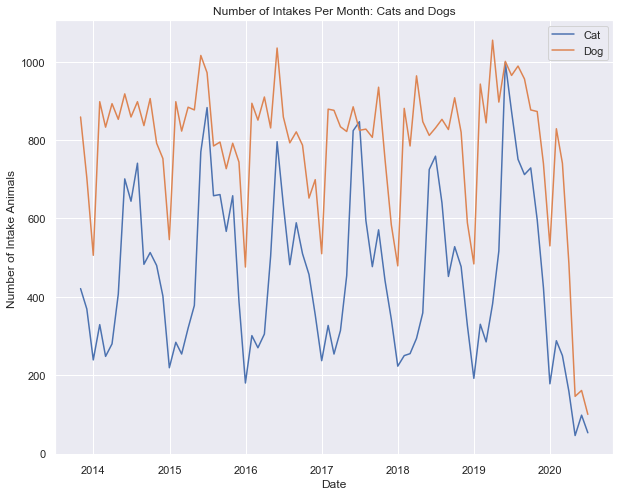

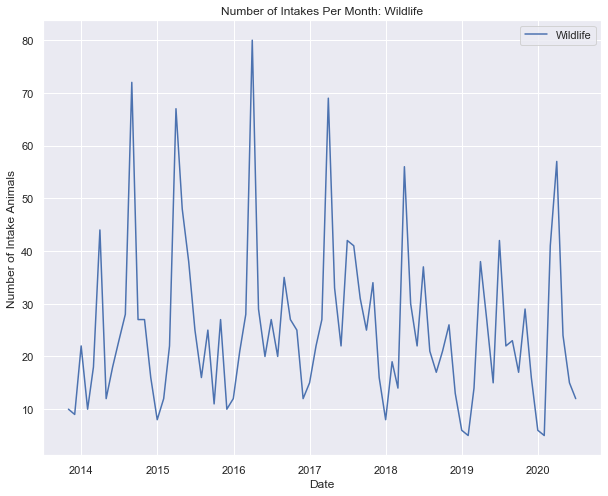

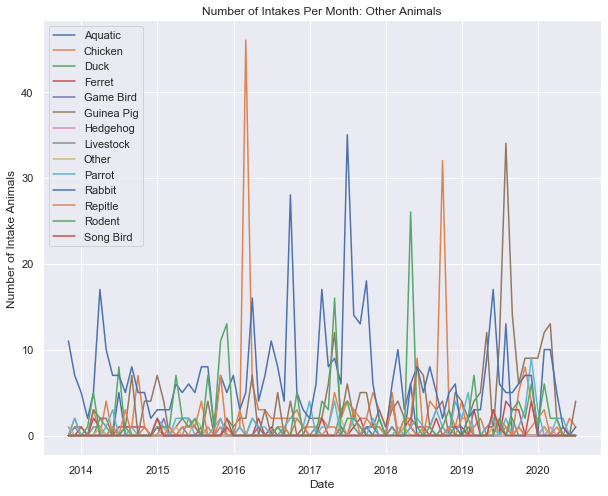

In [64]:
# Plotting intake over time
summed_dfs = [summed_cat_dog, summed_wildlife, summed_small]
df_names = ['Cats and Dogs', 'Wildlife', 'Other Animals']
for i, sum_df in enumerate(summed_dfs):
    
    sum_df = sum_df.fillna(0)
#     sum_df_name = 
    
    plt.figure(figsize=(10,8))
    
    for col in sum_df.columns.to_list():
        plt.plot(sum_df.index, sum_df[col], label=f"{col}")

    plt.title(f"Number of Intakes Per Month: {df_names[i]}")
    plt.ylabel("Number of Intake Animals")
    plt.xlabel("Date")
    plt.legend()
#   plt.savefig(f"images/intakepermonth_{df_names[i].lower().replace(' ', '')}")
    plt.show()

In [26]:
# Prepare a cat df to show annual trends
summed_cats = summed_cat_dog[['Cat']]
summed_cats['year'] = summed_cats.index.year
summed_cats['month'] = summed_cats.index.month

In [27]:
# List of years in df
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

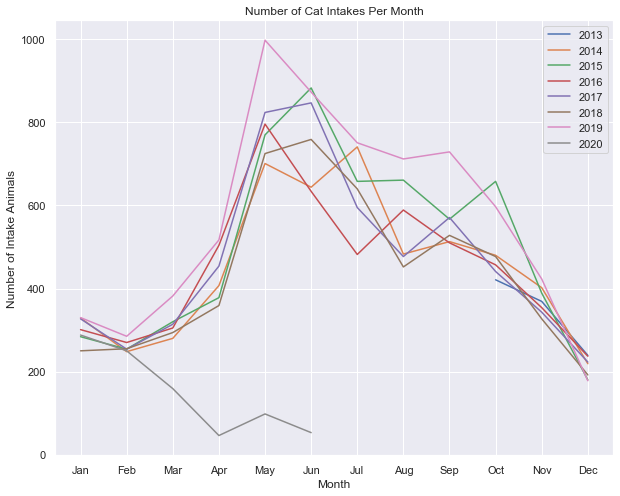

In [65]:
plt.figure(figsize=(10, 8))

for year in years:
    year_cats = summed_cats.loc[summed_cats['year'] == year]

    plt.plot(year_cats['month'], year_cats["Cat"], label=f"{year}")

plt.title("Number of Cat Intakes Per Month")
plt.ylabel("Number of Intake Animals")
plt.xlabel("Month")
plt.xticks(ticks=range(1, 13),
           labels=["Jan", "Feb", "Mar", "Apr",
                   "May", "Jun", "Jul", "Aug",
                   "Sep", "Oct", "Nov", "Dec"])
plt.legend()
# plt.savefig(f"images/intakepermonth_cat_seasonal")
plt.show()

### Intake Pattern Findings: 

- The intake of cats and dogs seems to have a seasonal pattern that remains relatively constant
- Wildlife also seems fairly seasonal, with perhaps a slight downward trend since 2017
- For those animals who have seasonal patterns, winter is a low time for all
- Small, non-wildlife animals *do* appear to have sudden spikes

We can see strong seasonality in the intake of cats per year, with sharp intake increases during late spring/early summer months - consistent with kitten season!

## Spay/Neuter

Neutering of animals at the Austin Animal Center is funded by [The City of Austin and Travis County](https://www.austintexas.gov/page/no-kill-plan), but how many neuterings are they doing a month? Is that number increasing or decreasing? By comparing the variables `sex_upon_intake` and `sex_upon_outcome` for each animal, a change in status from "intact" to "spayed/neutered" reveals the animal was fixed during their stay at the Rescue Center.

Here we will mostly look at dogs and cats, since they comprise over 95% of our data.

In [62]:
# Get percent intact
intact_count = animal_df.loc[(animal_df.species.str.contains("Dog|Cat")) & (
    animal_df.sex_upon_outcome.str.contains("Intact"))]\
    .outcome_type.value_counts(normalize=True).sort_index()

# Get percent neutered
fixed_count = animal_df.loc[(animal_df.species.str.contains("Dog|Cat")) & (
    animal_df.sex_upon_outcome.str.contains("Neutered|Spayed"))]\
    .outcome_type.value_counts(normalize=True).sort_index()

total_count = pd.DataFrame()
total_count['percent_intact'] = intact_count
total_count['percent_fixed'] = fixed_count

In [63]:
total_count = total_count.applymap(lambda x: f"{x * 100:.2f}")
total_count

,percent_intact,percent_fixed
Adoption,8.16,64.41
Died,2.35,0.19
Disposal,0.13,0.01
Euthanasia,4.71,1.25
Missing,0.16,0.03
Return to Owner,21.28,16.75
Rto-Adopt,0.25,0.84
Transfer,62.97,16.52


### Spay/Neuter Outcome Findings:

Here we can see that outcomes for intact vs. fixed dogs and cats vary widely - most fixed dogs/cats are adopted out (64%), while most intact dogs/cats are transferred. More research would need to be done to investigate what Austin Animal Shelter means when they say "transfer" in this context.

Note! Correlation does not imply causation - it could be that animals are fixed in the Center's care when they are likely to be adopted, etc. 

In [55]:
# Create 'fixed' indicator column
animal_df['fixed'] = np.where((animal_df['sex_upon_intake'].str.contains(
    'Intact') == True) & (animal_df['sex_upon_outcome'].str.contains("Neutered|Spayed")), 1, 0)

In [49]:
# Grab fixed cats and dogs
fixed_df = animal_df.loc[(animal_df['species'].str.contains("Dog|Cat")) & (animal_df.fixed == 1)]\
    .groupby([pd.Grouper(key="date_intake", freq='1M'), 'species']).count()\
    .reset_index().pivot(index='date_intake', columns='species', values='animal_id')

# Rename the columns
fixed_df.columns = ['cat_fixed', "dog_fixed"]

fixed_df.head()

,cat_fixed,dog_fixed
date_intake,,
2013-10-31,207,418
2013-11-30,155,353
2013-12-31,84,228
2014-01-31,113,450
2014-02-28,88,445


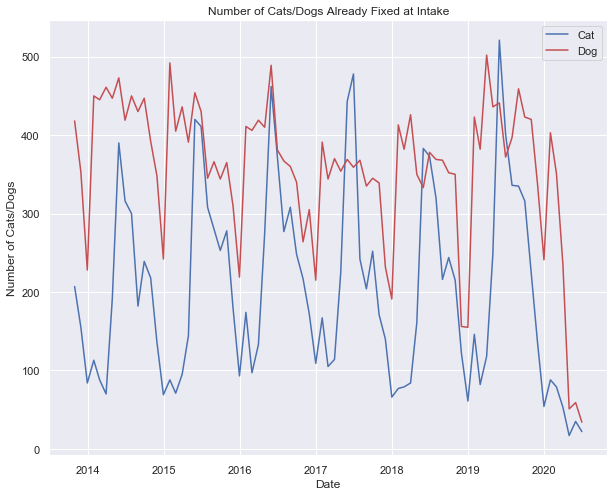

In [69]:
# Plot how num of animals fixed at intake changes over time
plt.figure(figsize=(10,8))

plt.plot(fixed_df.index, fixed_df['cat_fixed'], label="Cat", color="b")
plt.plot(fixed_df.index, fixed_df['dog_fixed'], label="Dog", color="r")

plt.title("Number of Cats/Dogs Already Fixed at Intake")
plt.xlabel("Date")
plt.ylabel("Number of Cats/Dogs")
plt.legend()
# plt.savefig(f"images/fixedatintake_num")
plt.show()

In [51]:
# Now finding percentages
# Add in the above cat dog counts
fixed_perc = pd.concat([summed_cat_dog, fixed_df], axis=1)
# Now grab percentages
fixed_perc['percent_cat'] = fixed_perc.cat_fixed/fixed_perc.Cat
fixed_perc['percent_dog'] = fixed_perc.dog_fixed/fixed_perc.Dog
fixed_perc = fixed_perc.drop(columns=['Cat', 'Dog', 'cat_fixed', 'dog_fixed'])
# Rename the columns
fixed_perc.columns = ['Cat', 'Dog']

fixed_perc.head()

,Cat,Dog
date_intake,,
2013-10-31,0.491686,0.486612
2013-11-30,0.420054,0.501420
2013-12-31,0.351464,0.450593
2014-01-31,0.343465,0.501114
2014-02-28,0.354839,0.534214


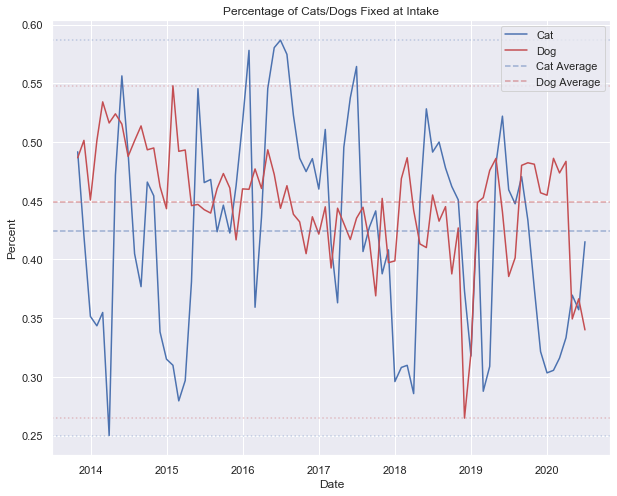

In [71]:
# Plot how percentage of animals fixed at intake changes over time
plt.figure(figsize=(10,8))

plt.plot(fixed_perc.index, fixed_perc['Cat'], label="Cat", color="b")
plt.plot(fixed_perc.index, fixed_perc['Dog'], label="Dog", color="r")

# Dashed lines to show average per animal type
plt.axhline(fixed_perc['Cat'].mean(), linestyle="dashed", 
            color="b", alpha=.5, label="Cat Average")
plt.axhline(fixed_perc['Dog'].mean(), linestyle="dashed", 
            color="r", alpha=.5, label="Dog Average")

# Additional dotted lines to show min/max context
plt.axhline(fixed_perc['Cat'].min(), linestyle="dotted", 
            color="b", alpha=.3)
plt.axhline(fixed_perc['Cat'].max(), linestyle="dotted", 
            color="b", alpha=.3)
plt.axhline(fixed_perc['Dog'].min(), linestyle="dotted", 
            color="r", alpha=.3)
plt.axhline(fixed_perc['Dog'].max(), linestyle="dotted", 
            color="r", alpha=.3)

plt.title("Percentage of Cats/Dogs Fixed at Intake")
plt.ylabel("Percent")
plt.xlabel("Date")
plt.legend()
# plt.savefig(f"images/fixedatintake_perc")
plt.show()

### Spay/Neuter Findings:

- cats are less likely to come in already spayed/neutered
- dogs have less variance over time in whether or not they're likely to come in already fixed

## Business Recommendations

- typically, dog/cat intake is seasonal, so Center should predict and prepare for upticks in intake during spring/summer
- while infrequent, have staff be prepared for spikes in small animal care
- neutering workload is predictable
- neutered pets get adopted at higher rates, so continue to fix incoming dogs/cats

## Limitations

- Missing animals that came back to the shelter more than one time during a year
- Not examining animals still in the shelter
- Do not know specific costs of care or current staffing of Rescue Center
- Consistent dips in January and December might be due to how we merged the data on year, so artifical dip
